# LAB 1
All the code and explainations are given in this notebook.

# Task 1

  0%|          | 0/12001 [00:00<?, ?it/s]

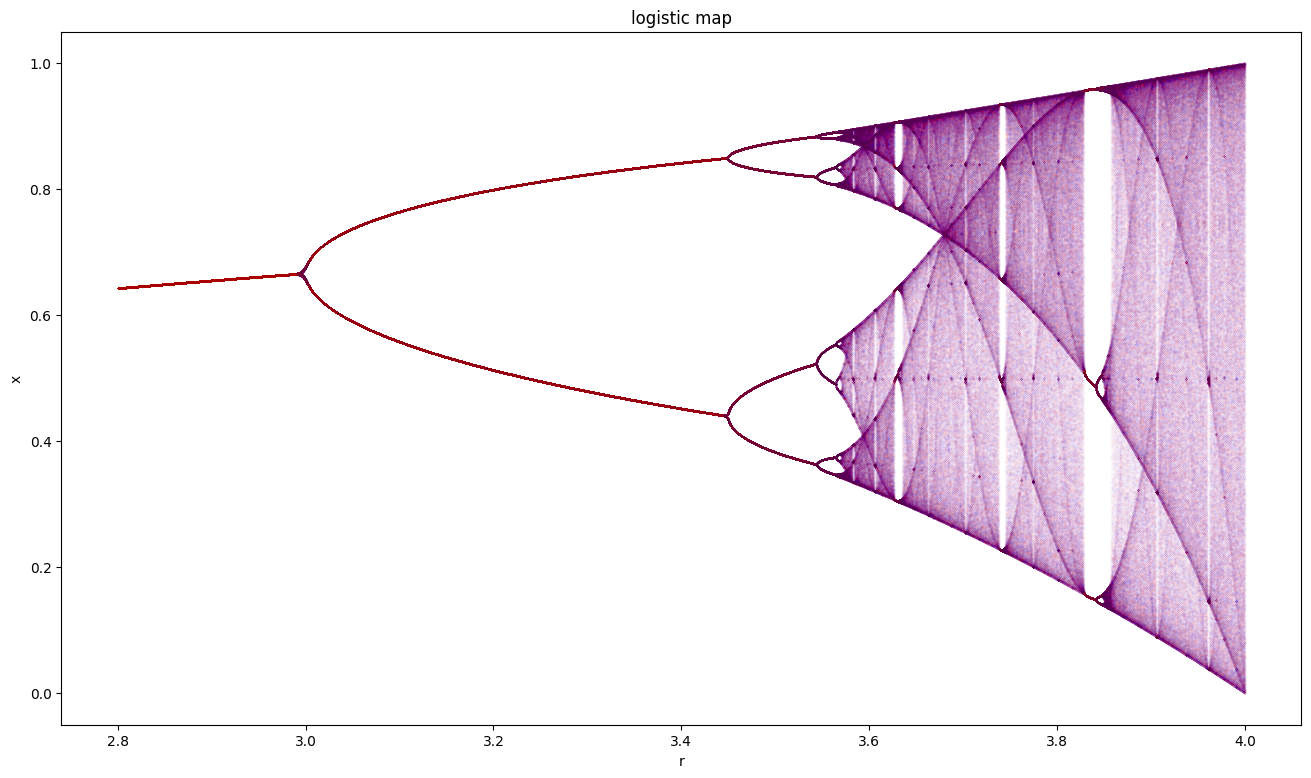

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

interval = (2.8, 4)  # start, end
accuracy = 0.0001
reps = 600  # number of repetitions
numtoplot = 200
a = 1e-5

lims = np.zeros(reps)
lims2 = np.zeros(reps) # initialize for the plot with perturbations

def perturbation(x):
    return a*x**4
    
    
fig, biax = plt.subplots()
fig.set_size_inches(16, 9)

lims[0] = np.random.rand()
lims2[0] = lims[0].copy() # creating the same initial condition as the unperturbed version

for r in tqdm(np.arange(interval[0], interval[1], accuracy)):
    for i in range(reps-1):
        lims[i+1] = r*lims[i]*(1-lims[i])
        lims2[i+1] = r*lims2[i]*(1-lims2[i]) + perturbation(lims2[i])
    
    # without perturbation
    biax.plot([r]*numtoplot, lims[reps-numtoplot:], 'b.', markersize=.02) 
    # with perturbation
    biax.plot([r]*numtoplot, lims2[reps-numtoplot:], 'r.', markersize=.02)


biax.set(xlabel='r', ylabel='x', title='logistic map')
plt.show()

# Task 2
Compute the Feigenbaum constants $\alpha\approx 2.5029$ and $\beta\approx4.6692$
for both maps. $\alpha$ is defined as ...
$\beta = \lim_{n\rightarrow \infty} \frac{a_{n-1} - a_{n-2}}{a_n - a_{n-1}}$ where $a_n$ is 